# **IVAN FALCON MONZON**

TAREA 9 - (24-25) DQN MOUNTAIN CAR CONTINUOUS

### **Descripción:** Implementación de un agente basado en DQN para resolver MountainCarContinuous-v0 usando acciones discretizadas.

## Importar librerías necesarías

In [ ]:
# IVAN FALCON MONZON
# Importación de librerías necesarias
import numpy as np
import gym  # Entorno de simulación
import random  # Para muestreo aleatorio en la memoria de experiencias
import matplotlib.pyplot as plt  # Para graficar los resultados
from collections import deque  # Estructura de datos para almacenar experiencias
from keras.models import Sequential  # Modelo de red neuronal
from keras.layers import Dense  # Capas densas para la red neuronal
from keras.optimizers import Adam  # Optimizador para la red neuronal
import imageio  # Para la grabación y almacenamiento de videos
from gym.wrappers import RecordVideo  # Envoltura para grabar videos de las simulaciones

# **1. Configuración del entorno**

### Se define el entorno MountainCarContinuous-v0 y se configuran los hiperparámetros.

In [ ]:
# IVAN FALCON MONZON

env = gym.make("MountainCarContinuous-v0")
state_size = env.observation_space.shape[0]  # 2 valores: posición y velocidad
action_size = 5  # Acciones discretas

DISCRETE_ACTIONS = np.linspace(-1, 1, num=5)  # Acciones discretas entre -1 y 1

gamma = 0.99  # Factor de descuento
learning_rate = 0.001  # Tasa de aprendizaje

epsilon = 1.0  # Exploración inicial
epsilon_min = 0.02  # Exploración mínima
epsilon_decay = 0.999  # Reducción de exploración más rápida

memory = deque(maxlen=20000)  # Memoria de experiencias

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# **2. Construcción de la red neuronal**

### Se define una red neuronal con 3 capas ocultas para aproximar la función de valor Q.

In [ ]:
# IVAN FALCON MONZON
def build_model(): # Definimos la arquitectura de la red neuronal
    model = Sequential([
        Dense(128, input_dim=state_size, activation='relu'), # Capa de entrada con 128 neuronas y ReLU,
        Dense(256, activation='relu'),                                     # Capas ocultas con 256 neuronas y ReLU,
        Dense(256, activation='relu'),                                      # Capas ocultas con 256 neuronas y ReLU,
        Dense(len(DISCRETE_ACTIONS), activation='linear')  # Capa de salida con valores Q para cada acción  # 5 salidas (acciones discretas)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))  # Se usa MSE como función de pérdida y Adam como optimizador
    return model

model = build_model()  # Inicializamos la red neuronal

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **3. Selección de acciones**

### Se implementa una estrategia ε-greedy para balancear exploración y explotación.

La estrategia ε-greedy se usa para equilibrar exploración (probar nuevas acciones) y explotación (elegir la mejor acción conocida).

* Exploración (ε alto): Con probabilidad ε, el agente elige una acción aleatoria para descubrir nuevas estrategias.
* Explotación (ε bajo): Con probabilidad 1-ε, el agente elige la mejor acción conocida según sus Q-values.

In [ ]:
# IVAN FALCON MONZON
# 3. Función para seleccionar acciones
def act(state):  # Selecciona una acción basada en la estrategia ε-greedy
    if np.random.rand() <= epsilon:  # Con probabilidad ε, elige una acción aleatoria (exploración)
        action_idx = np.random.randint(0, len(DISCRETE_ACTIONS))  # Selecciona una acción aleatoria del conjunto de acciones discretas  # Exploración aleatoria
    else:
        q_values = model.predict(state, verbose=0)  # Predice los valores Q de todas las acciones posibles para el estado dado
        action_idx = np.argmax(q_values)  # Selecciona la acción con el mayor valor Q (explotación)  # Mejor acción según Q-values

    return np.array([DISCRETE_ACTIONS[action_idx]])  # Devuelve la acción seleccionada en el formato requerido por env.step()  # Array para env.step()

- Si np.random.rand() <= epsilon, elige una acción al azar.
- Si no, elige la acción con el mejor Q-value actual.
- epsilon empieza alto (explora más) y se reduce con epsilon_decay, permitiendo que el agente explore primero y explote después.

## **4. Almacenamiento de experiencias**

### Se almacena cada transición en la memoria de repetición.

In [ ]:
# IVAN FALCON MONZON
# 4. Función para almacenar experiencias
def remember(state, action, reward, next_state, done):  # Almacena experiencias en la memoria de repetición
    memory.append((state, action, reward, next_state, done))  # Guarda la transición para el entrenamiento futuro

## **5. Entrenamiento del agente**

### Se usa Q-learning con replay buffer para actualizar la red neuronal.

In [ ]:
# IVAN FALCON MONZON
# 5. Función de entrenamiento

def replay(batch_size=64):  # Reducimos el tamaño del lote (batch_size) para acelerar el entrenamiento
    # Si la memoria no tiene suficientes experiencias, no se realiza el entrenamiento
    if len(memory) < batch_size:
        return

    # Seleccionamos un minibatch aleatorio de experiencias de la memoria
    minibatch = random.sample(memory, batch_size)

    # Listas para almacenar los estados y los valores objetivos (targets) para el entrenamiento
    states, targets = [], []

    # Iteramos sobre cada experiencia en el minibatch
    for state, action, reward, next_state, done in minibatch:

        # Convertimos la acción en un índice correspondiente en el espacio de acciones discretas
        action_idx = np.where(DISCRETE_ACTIONS == action[0])[0][0]  # Convertir acción a índice

        # Obtenemos el valor Q actual para el estado dado
        target = model.predict(state, verbose=0)[0]

        # Si el episodio ha terminado, usamos la recompensa final como el valor Q objetivo
        if done:
            target[action_idx] = reward  # Si el episodio termina, usar la recompensa final
        else:
            # Si no ha terminado, calculamos el valor Q objetivo usando la ecuación de Q-learning
            next_q_values = model.predict(next_state, verbose=0)[0]
            target[action_idx] = reward + gamma * np.max(next_q_values)  # Q-learning update

        # Agregamos el estado y el valor objetivo a las listas
        states.append(state[0])
        targets.append(target)

    # Entrenamos el modelo utilizando los estados y targets obtenidos, mezclando los datos para evitar sesgo
    model.fit(np.array(states), np.array(targets), epochs=1, verbose=0, batch_size=batch_size, shuffle=True)

## **6. Ejecución del entrenamiento**

### Se ejecuta el entrenamiento del agente durante varios episodios.

In [ ]:
# IVAN FALCON MONZON
# 6. Entrenamiento del agente

# Número de episodios de entrenamiento (más episodios para un mejor aprendizaje)
episodes = 250  # Número de los episodios
rewards_per_episode = []  # Lista para almacenar las recompensas de cada episodio

# Iteración sobre cada episodio
for e in range(episodes):
    # Reiniciamos el entorno al comienzo de cada episodio
    state = env.reset()

    # Si el entorno devuelve una tupla (en algunos entornos de Gym), extraemos solo el estado
    if isinstance(state, tuple):
        state = state[0]

    # Remodelamos el estado para que sea compatible con la entrada del modelo (1, state_size)
    state = np.reshape(state, [1, state_size])

    # Inicializamos la recompensa total para el episodio actual
    total_reward = 0

    # Definimos el número máximo de pasos por episodio
    max_steps = 200

    # Iteración sobre cada paso dentro del episodio
    for step in range(max_steps):
        # Seleccionamos una acción usando la política actual
        action = act(state)

        # Realizamos el paso en el entorno, obteniendo el siguiente estado, recompensa, y si terminó el episodio
        step_result = env.step(action)
        if len(step_result) == 5:
            next_state, reward, done, _, _ = step_result  # Para entornos que devuelven 5 valores
        else:
            next_state, reward, done, _ = step_result  # Para entornos que devuelven 4 valores

        # Remodelamos el siguiente estado para que sea compatible con la entrada del modelo
        next_state = np.reshape(next_state, [1, state_size])

        # Modificamos la recompensa para incentivar el movimiento hacia la derecha
        if np.squeeze(next_state)[0] >= env.goal_position:
            reward = 500  # Asignamos una mayor recompensa al alcanzar la meta
        else:
            reward += 10 * abs(next_state[0][1])  # Premiar velocidades más altas

        # Almacenamos la experiencia (estado, acción, recompensa, siguiente estado, si terminó el episodio)
        remember(state, action, reward, next_state, done)

        # Actualizamos el estado actual con el siguiente estado
        state = next_state

        # Acumulamos la recompensa total
        total_reward += reward

        # Si el episodio terminó, reducimos la exploración (epsilon) y salimos del bucle
        if done:
            epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Reducir epsilon gradualmente
            break

    # Al final del episodio, guardamos la recompensa total obtenida
    rewards_per_episode.append(total_reward)

    # Imprimimos la recompensa total obtenida en el episodio actual
    print(f"Episodio: {e+1}, Recompensa: {total_reward}")

    # Realizamos un paso de entrenamiento con un minibatch de experiencias
    replay(128)  # El valor 128 es el tamaño del batch que se usará en el entrenamiento

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio: 1, Recompensa: 0.6150688295601854
Episodio: 2, Recompensa: -5.218645410692268
Episodio: 3, Recompensa: 2.450110079045407
Episodio: 4, Recompensa: -0.28285178954538437
Episodio: 5, Recompensa: 7.398510078476826
Episodio: 6, Recompensa: 7.6639429490956905
Episodio: 7, Recompensa: -3.976043407886391
Episodio: 8, Recompensa: 1.889195675395603
Episodio: 9, Recompensa: 1.6611586515384271
Episodio: 10, Recompensa: 0.08973130937956683
Episodio: 11, Recompensa: 3.2832588942721483
Episodio: 12, Recompensa: 2.878109880279225
Episodio: 13, Recompensa: 2.8025495407506233
Episodio: 14, Recompensa: -4.572561573542772
Episodio: 15, Recompensa: -0.5228744835576437
Episodio: 16, Recompensa: 6.247332417202416
Episodio: 17, Recompensa: 3.3367131847553537
Episodio: 18, Recompensa: 3.9999070431222195
Episodio: 19, Recompensa: 0.7821314275744945
Episodio: 20, Recompensa: -3.545792152827199
Episodio: 21, Recompensa: -4.0954067501125335
Episodio: 22, Recompensa: -4.4616316337142035
Episodio: 23, Reco

## **7. Visualización del rendimiento**

### Se visualiza el progreso del aprendizaje a través de la recompensa obtenida en cada episodio

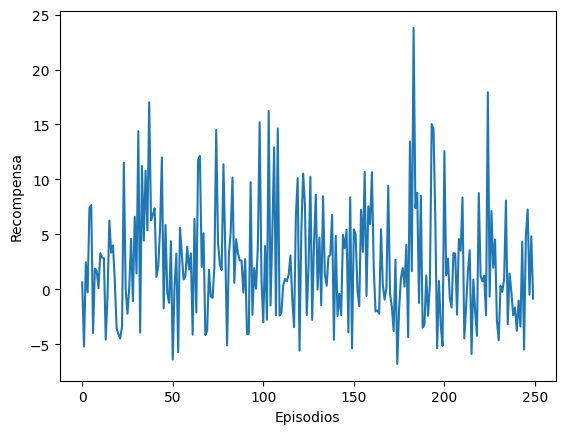

In [ ]:
# IVAN FALCON MONZON
# 7. Evaluación y visualización

# Grafica de las recompensas obtenidas por episodio a lo largo del entrenamiento
plt.plot(rewards_per_episode)

# Etiqueta para el eje X (número de episodios)
plt.xlabel("Episodios")

# Etiqueta para el eje Y (recompensa obtenida en cada episodio)
plt.ylabel("Recompensa")

# Mostrar la gráfica
plt.show()

## **8. Grabación y visualización del video**

### Se graba un video de la ejecución del agente en el entorno.

In [ ]:
# IVAN FALCON MONZON
# 8. Guardar y reproducir video de ejecución

# Función para grabar el video de la ejecución del agente en el entorno de Gym
def record_video():
    # Crear un entorno de grabación de video. Cada episodio activará la grabación.
    video_env = RecordVideo(env, "./video", episode_trigger=lambda x: True)

    # Inicializar el entorno
    state = video_env.reset()
    if isinstance(state, tuple):
        state = state[0]  # Extraer solo el estado si env.reset() devuelve una tupla
    state = np.reshape(state, [1, state_size])

    done = False
    while not done:
        # El agente toma una acción en función del estado actual
        action = act(state)

        # El entorno realiza un paso, devuelve el siguiente estado, recompensa, etc.
        step_result = video_env.step(action)

        # Si el entorno devuelve 5 valores (como en el caso de MountainCar), desempacamos
        if len(step_result) == 5:
            next_state, _, done, _, _ = step_result
        else:
            next_state, _, done, _ = step_result

        next_state = np.reshape(next_state, [1, state_size])
        state = next_state

    # Cerramos el entorno de grabación y confirmamos que el video ha sido guardado
    video_env.close()
    print("Video guardado en la carpeta ./video")

    # Retornar la ruta del video guardado
    return "./video/rl-video-episode-0.mp4"  # Nombre correcto del video guardado

# Llamamos a la función para grabar el video
video_path = record_video()

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.i

Video guardado en la carpeta ./video
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

### Video en Google Colab

In [ ]:
# IVAN FALCON MONZON
# Convertir el video a un formato compatible con Colab
!ffmpeg -i ./video/rl-video-episode-0.mp4 -vcodec libx264 ./video/mountaincar_video_fixed.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
# Función para mostrar el video en base64
from IPython.display import HTML
import base64

def display_video(video_path):
    # Abrir el archivo de video en modo binario y leer su contenido
    video_file = open(video_path, "r+b").read()

    # Convertir el contenido del video a base64 para incrustarlo en HTML
    video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"

    # Crear el código HTML para mostrar el video en Colab con controles
    return HTML(f"""
    <video width=600 controls>
        <source src="{video_url}" type="video/mp4">
    </video>
    """)

In [ ]:
# Mostrar el video
display_video("./video/mountaincar_video_fixed.mp4")

# **Repositorio Github**

Enlace: https://github.com/IvanFalconMonzon/TA9_DQN-MOUNTAIN-CAR-CONTINUOUS_IVANFALCONMONZON.git